# Decision Trees

In this notebook we discuss another popular classification algorithm, decision trees. 

A decision tree is quite intuitive and a building block for an often used algorithm, random forests (more on those later). Trees can be made to perform both regression and classification tasks. We'll focus on classification in this notebook and if you're interested you can build a regression tree in the homework.

## What You'll Accomplish

<ul>
    <li>We'll introduce the decision tree algorithm with a dumb example,</li>
    <li>Talk about the decision tree loss functions,</li>
    <li>Show how sklearn fits a tree,</li>
    <li>You'll make a tree to predict heart diseas,</li>
    <li>Touch on how sklearn handles categorical features and decision trees.</li>
</ul>



In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## The Basic Idea

The basic idea for decision trees is segmenting the data space in a way that allows us to classify the data well.

### A Dumb Example

Let's look at a really dumb example. Below we generate some random data with an $x_1$ feature, an $x_2$ feature, and a target, $y$. We then plot the data using seaborn. 

In [2]:
df = pd.DataFrame({'x1':np.random.random(200),'x2':np.random.random(200),'y':np.zeros(200)})

df.loc[100:199,['x1']] = df.loc[100:199,['x1']] + 1
df.loc[100:199,['y']] = df.loc[100:199,['y']] + 1

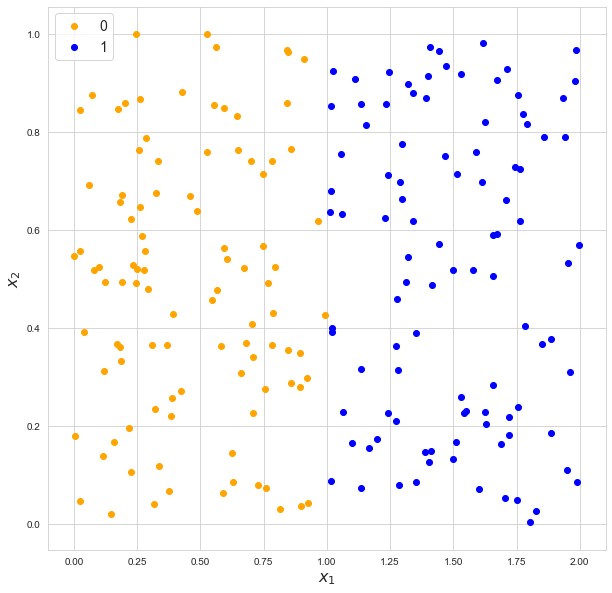

In [3]:
plt.figure(figsize = (10,10))
plt.scatter(df.loc[df.y == 0,'x1'],df.loc[df.y == 0,'x2'],c='orange',label="0")
plt.scatter(df.loc[df.y == 1,'x1'],df.loc[df.y == 1,'x2'],c='blue',label="1")
plt.xlabel("$x_1$",fontsize = 16)
plt.ylabel("$x_2$",fontsize = 16)
plt.legend(fontsize='14', title_fontsize='16')

plt.show()

Now if you had to come up with an adhoc classification rule right now what would you say we should do?

<br>
<br>
<br>

One good choice would be to say that if the data point is to the left of $x_1= 1$ then we classify it as $0$, and if it to the right of $x_1=1$ then we classify it as $1$. We can illustrate this with a logic tree
<img src = "SimpleTree.png" style="width:60%"></img>
While this is a very dumb example, it is the basic idea behind decision trees. You look at a feature, make a cut point that minimizes some measure of wrongness, and keep going until some stopping criterion.

Before we move on to real data, let's fit a decision tree to our dumb data and see what classification rule it comes up with.

In [4]:
# Import packages
# tree will be used to plot the decisiton tree
from sklearn import tree

# This is the actual out of the box algorithm
from sklearn.tree import DecisionTreeClassifier

In [5]:
# Make an decisiion tree object
tree_clf = DecisionTreeClassifier(random_state = 440)

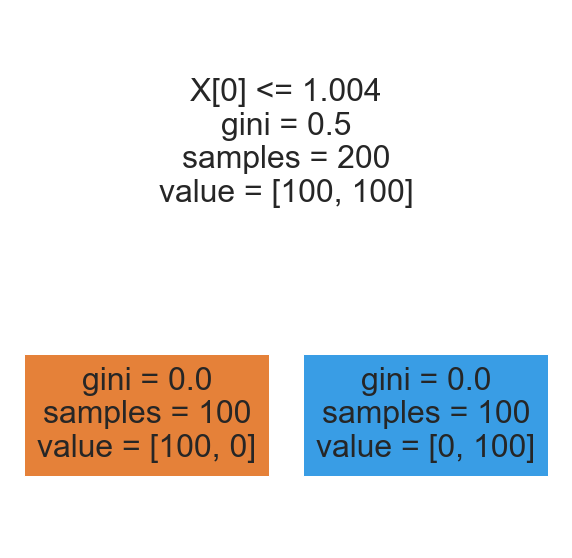

In [6]:
plt.figure(figsize = (10,10))
# Plot the fitted tree
fig = tree_clf.fit(df[['x1','x2']], df.y)
tree.plot_tree(fig,filled = True)
plt.show()


The plot above is the logic tree built by the decision tree algorithm. To classify a new observation we start at the <i>root node</i> up top. If the observation satisfies the logic statement at the top we go left and are classified as a $0$, else we go right and are classified as $1$. The two <i>children</i> of the root node are known as <i>leaf nodes</i> or <i>terminal nodes</i> because they have no children of their own so we just predict the majority class contained in that node.

This is essentially the decision rule we came up with (which is the objectively correct one by the way), so in this dummy example the decision tree did well.


If we look in the plot above we'll notice a number of different stats in each node. Let's quickly break those down. 

<ul>
    <li>samples - the number of samples in each node</li>
    <li>gini - the gini impurity of the node, more on this in a moment</li>
    <li>value - the breakdown of the number of samples of each target value in the node, for example the leaf node on the left has $100$ nodes labeled $0$ and $0$ nodes labeled $1$</li>
    <li>A decision rule - The rule that is used for the following split, samples that would be evaluated as True for the rule go to the left child, samples that would be evaluated as False go to the right child</li>
</ul>

### How is Wrongness Measured?

There are a couple of ways to measure wrongness, or rather impurity, with decision trees. We'll briefly touch on two popular measures that can implemented with out of the box `sklearn`.

#### Gini Impurity

Suppose that there are $N$ target classes.

The Gini Impurity for class $i$ of a node estimates the probability that a randomly chosen sample of class $i$ from the node is incorrectly classified as not class $i$. The formula is:
$$
G_i = p_i(1-p_i)
$$
where $p_i$ is the proportion of samples in the node of class $i$. The total Gini Impurity is the sum of all these $G_i$
$$
I_G = \sum_{i=1}^N G_i = 1 - \sum_{i=1}^N p_i^2
$$


#### Entropy

Entropy is an alternative impurity measure you could use when building a decision tree in `sklearn`. It's origins are in thermodynamics, but it soon moved into a diverse array of fields including information theory which is how it ended up in machine learning applications.

Again suppose there are $N$ target classes. The contribution made to entropy from class $i$ is:
$$
H_i = - p_i \log(p_i),
$$
where again $p_i$ is the proportion of samples in the node of class $i$. The total entropy of the node is the sum of all the $H_i$:
$$
I_H = \sum_{i=1}^N H_i = -\sum_{i=1}^N p_i \log(p_i) 
$$

#### Which to use

In most cases both measures are comparable, with Gini impurity being faster to compute (the $\log$ in entropy take more time for a computer) it is a good default. It has been found that entropy leads to more balanced trees, https://sebastianraschka.com/faq/docs/decision-tree-binary.html, than Gini Impurity.

## How `sklearn` Fits a Tree

Now that we understand how to measure the impurity of a node, we can see how `sklearn` decides to make a node cut.

### The CART Algorithm

`sklearn` uses the <i>Classification and Regression Tree</i> or <i>CART</i> algorithm. 

Suppose your data set has $n$ observations with $m$ features, and for simplicity only $2$ target classes.

The algorithm starts with the root node. It then searches through each feature, $k$, and finds a split point, $t_k$, that produces the purest subsets (weighted by the number of samples in each subset), i.e. it finds a $t_k$ that minimizes:
$$
J(k,t_k) = \frac{n_\text{left}}{n} I_\text{left} + \frac{n_\text{right}}{n} I_\text{right},
$$
where left and right refers to being left or right of the split point, $t_k$, and $I$ is the impurity measure you choose to use (the default is Gini). 

Once it finds the $(k,t_k)$ pair that has smallest $J(k,t_k)$, it splits the data according to that decision split.

The algorithm then repeats the entire process on each of the children nodes it just produced. This continues until some stopping condition for example:
<ul>
    <li>reaching a maximum depth</li>
    <li>reaching a minimum number of samples in each node</li>
    <li>reaching a minimum weight to be in a node</li>
    <li>etc.</li>
</ul>
or until it can no longer reduce the impurity by making a cut.

## Quick Break

Okay before we move on to building a decision tree on real data, let's take a break for any questions about the algorithm, impurity, or anything we just went over.


Ask now.


Now let's try to build a model with non randomly generated data.

## Practice - Classifying Heart Disease with a Decision Tree


We'll be building a model to classify instances of heart disease from a data set that can be found <a href = "https://archive.ics.uci.edu/ml/datasets/heart+Disease">here</a>.  I walk you through some preliminary data exploration then leave you it to you to build the model.


### The Data


Before any data exploration let's make a test train split.

In [7]:
# Import the data
# it is stored in the cleveland_heart csv
heart = pd.read_csv("cleveland_heart.csv")

# our target is whether or not there was heart disease
heart['target'] = 0
heart.loc[heart.status > 0,'target'] = 1


print("There are ",len(heart)," observations.")
print(sum(heart.target)," of those observations had heart disease")

There are  297  observations.
137  of those observations had heart disease


In [8]:
# Practice, make your train test split here!
# Keep the default of 25% set aside
# shuffle and stratify to ensure we keep the distr
# Set a random state of 614
from sklearn.model_selection import train_test_split

In [9]:
# Use this block if needed
X_train,X_test,y_train,y_test = train_test_split(heart.drop(columns = ['status','target']),
                                                heart[['target']], 
                                                shuffle = True,
                                                stratify = heart[['target']], 
                                                random_state = 614)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Okay now, using both the documentation and `pandas` explore the data set further before building a model. This will allow us to see if we need to do any cleaning before feeding the data into the algorithm.

Here are some questions you might want to know the answer to:
<ol>
    <li>Which variables are continuous? Categorical? Ordinal?</li>
    <li>What do each of the variables mean?</li>
    <li>How are the data values stored in the pandas dataframe? Is that appropriate for the data type?</li>
    <li>Do some variables appear to more important than others?</li>
</ol>

In [10]:
X_train.head()


# from uci, the data source 
# age - ordinal
# sex - categorical/binary
# cp - categorical/1,2,3,4
# trestbps - cont.
# chol - cont
# fbs - cat/bin
# restecg - cat/0,1,2
# thalach - cont
# exang - cat/bin
# oldpeak - cont
# slope - ordinal
# ca - ordinal
# thal - cat/3,6,7

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,48.0,1.0,4.0,124.0,274.0,0.0,2.0,166.0,0.0,0.5,2.0,0.0,7.0
1,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0
2,58.0,1.0,4.0,100.0,234.0,0.0,0.0,156.0,0.0,0.1,1.0,1.0,7.0
3,64.0,1.0,3.0,140.0,335.0,0.0,0.0,158.0,0.0,0.0,1.0,0.0,3.0
4,55.0,0.0,4.0,128.0,205.0,0.0,1.0,130.0,1.0,2.0,2.0,1.0,7.0


In [11]:
 X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 13 columns):
age         222 non-null float64
sex         222 non-null float64
cp          222 non-null float64
trestbps    222 non-null float64
chol        222 non-null float64
fbs         222 non-null float64
restecg     222 non-null float64
thalach     222 non-null float64
exang       222 non-null float64
oldpeak     222 non-null float64
slope       222 non-null float64
ca          222 non-null float64
thal        222 non-null float64
dtypes: float64(13)
memory usage: 22.7 KB


In [13]:
#### Code here 
# We should recode the non-binary qualitative variables
X_train[['cp','restecg','thal']] = X_train[['cp','restecg','thal']].astype(str)
X_test[['cp','restecg','thal']] = X_test[['cp','restecg','thal']].astype(str)

In [14]:
#### Code here 
# Let's examine the data by the target.
df_train = pd.concat([X_train,y_train],axis=1)

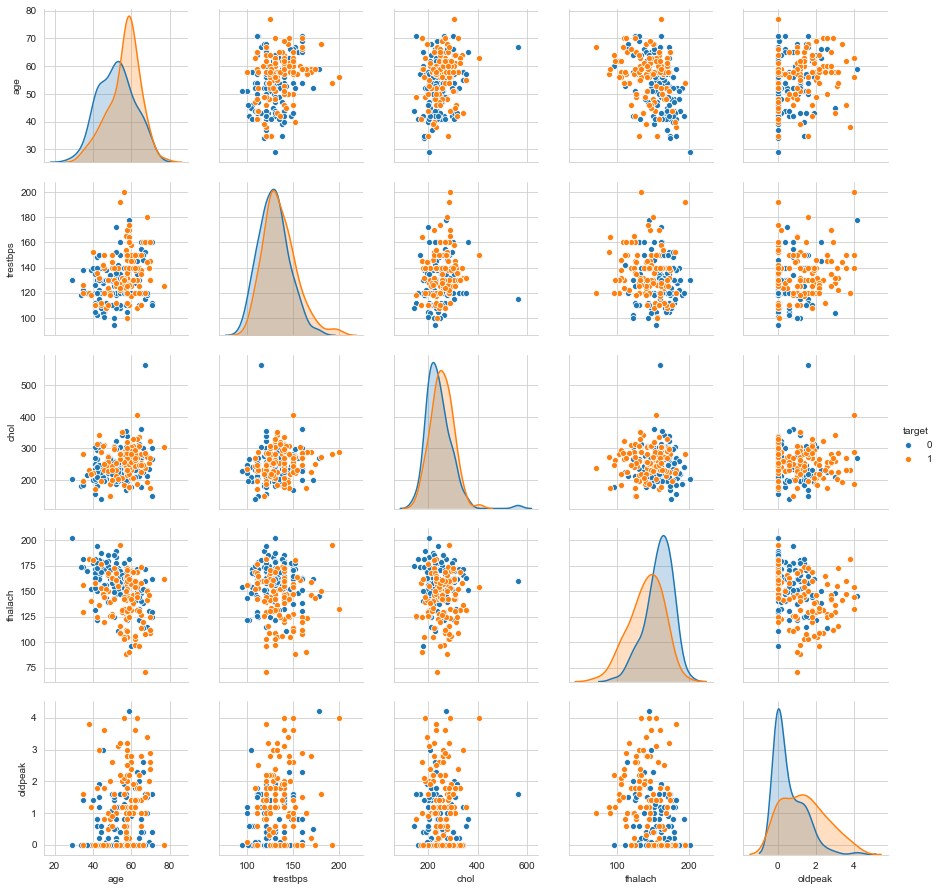

In [18]:
sns.pairplot(df_train,vars = ['age','trestbps','chol','thalach','oldpeak'],
                  hue='target')

plt.show()

It looks like the continuous features may not be helpful on their own. Let's try to explore the categorical variables.

In [19]:
df_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,48.0,1.0,4.0,124.0,274.0,0.0,2.0,166.0,0.0,0.5,2.0,0.0,7.0,1
1,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0,1
2,58.0,1.0,4.0,100.0,234.0,0.0,0.0,156.0,0.0,0.1,1.0,1.0,7.0,1
3,64.0,1.0,3.0,140.0,335.0,0.0,0.0,158.0,0.0,0.0,1.0,0.0,3.0,1
4,55.0,0.0,4.0,128.0,205.0,0.0,1.0,130.0,1.0,2.0,2.0,1.0,7.0,1


In [20]:
for feature in ['sex','cp','fbs','restecg','exang','slope','ca','thal']:
    print(df_train.groupby(feature).target.value_counts(normalize=True).sort_index())
    print()

sex  target
0.0  0         0.716418
     1         0.283582
1.0  0         0.464516
     1         0.535484
Name: target, dtype: float64

cp   target
1.0  0         0.777778
     1         0.222222
2.0  0         0.777778
     1         0.222222
3.0  0         0.757576
     1         0.242424
4.0  0         0.274510
     1         0.725490
Name: target, dtype: float64

fbs  target
0.0  0         0.545946
     1         0.454054
1.0  0         0.513514
     1         0.486486
Name: target, dtype: float64

restecg  target
0.0      0         0.651376
         1         0.348624
1.0      1         1.000000
2.0      0         0.437500
         1         0.562500
Name: target, dtype: float64

exang  target
0.0    0         0.668831
       1         0.331169
1.0    0         0.250000
       1         0.750000
Name: target, dtype: float64

slope  target
1.0    0         0.710526
       1         0.289474
2.0    0         0.354167
       1         0.645833
3.0    0         0.416667
       1    

Okay now that we have a better feel for the data, let's build a decision tree.

### Non-binary Categorical Variables

If you read `sklearn`'s docs on the decision tree classifier they use, it does not support the use of categorical variables at the time of the writing of these notes.

This leaves two options:
<ol>
    <li>One hot encoding</li>
    <li>Removing these variables from the algorithm</li>
</ol>

We'll do both here. However, in a later notebook we'll return to this issue and see if we should be okay with building tree on one hot encoded variables in practice.

#### Model Without Non-Binary Categorical Variables

Build a model based on the variables that aren't categorical with more than two categories.

Produce an idea of how good your model is based on its:
<ul>
    <li>accuracy</li>
    <li>precision</li>
    <li>recall</li>
</ul>


Play around with the hyper parameters of max_depth and min_samples_split.

##### Caution

You should use either cross validation or set aside a small chunk of data within the training set to test your trees on. This is because decision trees can be made to fit the data perfectly if they're allowed to get deep enough. While this is great for understanding the training data, it's definitely overfitting. 



In [21]:
## Code here
# Making functions to calculate various stats
## Accuracy
def get_acc(prediction,y):
    return np.round(np.sum(prediction == y)/len(y),5)*100
## Precision
def get_prec(prediction,y):
    positives = prediction[prediction == 1]
    return np.round(np.sum(positives == y[prediction == 1])/len(positives),5)*100
## Recall
def get_recall(prediction,y):
    ones = y[y==1]
    return np.round(np.sum(prediction[y==1] == ones)/len(ones),5)*100


In [32]:
# Code here
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone







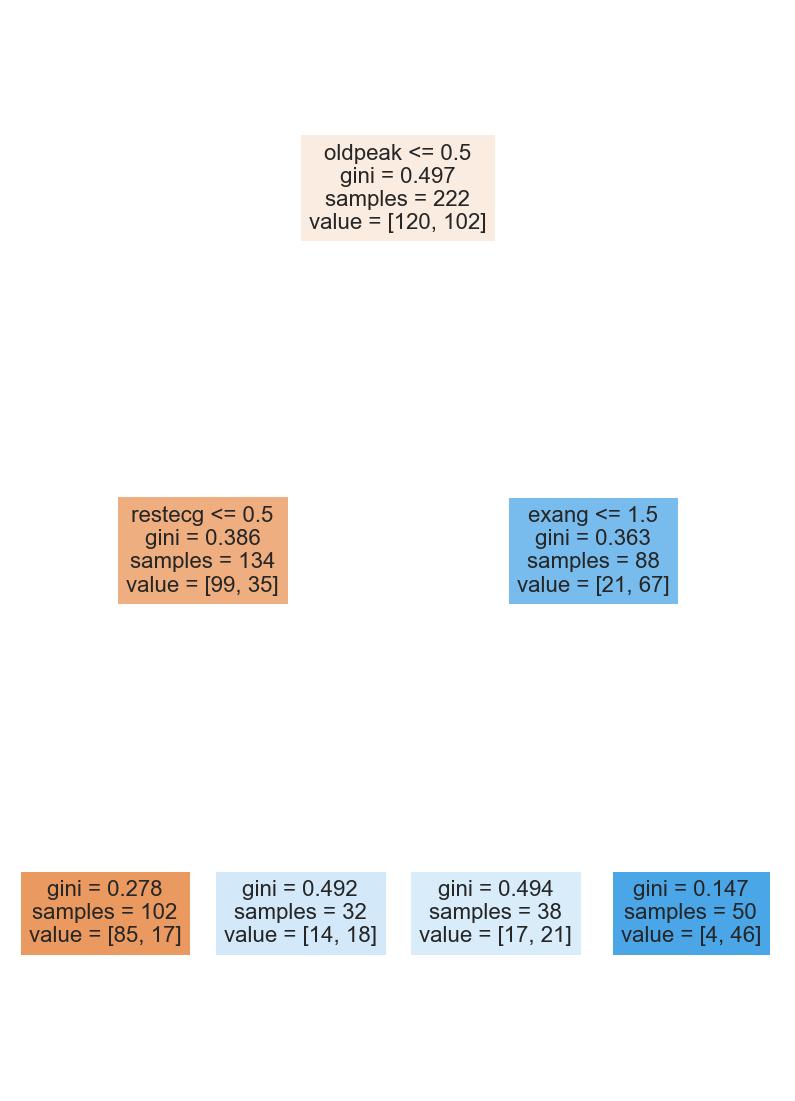

In [23]:
# Code Here

# A sample tree
tree_clf = DecisionTreeClassifier(random_state = 440,max_depth = 2)



plt.figure(figsize = (14,20))
# Plot the fitted tree
fig = tree_clf.fit(X_train[['age','sex','trestbps','chol','fbs','thalach','exang','oldpeak','slope','ca']],y_train)
tree.plot_tree(fig,filled = True,rotate=True,feature_names=X_train.columns)
plt.show()

In [33]:
# make the kfold object
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, random_state = 440, shuffle=True)

# Setting a max depth parameter
max_depth = 20

# make an empty array that will hold all of our accuracy measures
accs = np.empty([max_depth,n_splits])
prec = np.empty([max_depth,n_splits])
rec = np.empty([max_depth,n_splits])

# We'll go from 1 to max_depth as the max_depth parameter
for i in range(1,max_depth+1):
    # make knn
    tree_clf = DecisionTreeClassifier(random_state = 440,max_depth = i)
    # We'll get the accuracy for each split
    j = 1
    for k, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
        X_train_folds = X_train.loc[train_index,['age','sex','trestbps','chol','fbs','thalach','exang','oldpeak','slope','ca']]
        y_train_folds = y_train.loc[train_index,]
        X_test_fold = X_train.loc[test_index,['age','sex','trestbps','chol','fbs','thalach','exang','oldpeak','slope','ca']]
        y_test_fold = y_train.loc[test_index,]
        
        clone_tree = clone(tree_clf)
        clone_tree.fit(X_train_folds,y_train_folds)
        y_pred = clone_tree.predict(X_test_fold)
        accs[i-1,j-1] = get_acc(y_pred.reshape(-1,1),y_test_fold.values)
        prec[i-1,j-1] = get_prec(y_pred.reshape(-1,1),y_test_fold.values)
        rec[i-1,j-1] = get_recall(y_pred.reshape(-1,1),y_test_fold.values)
        j = j+1
        

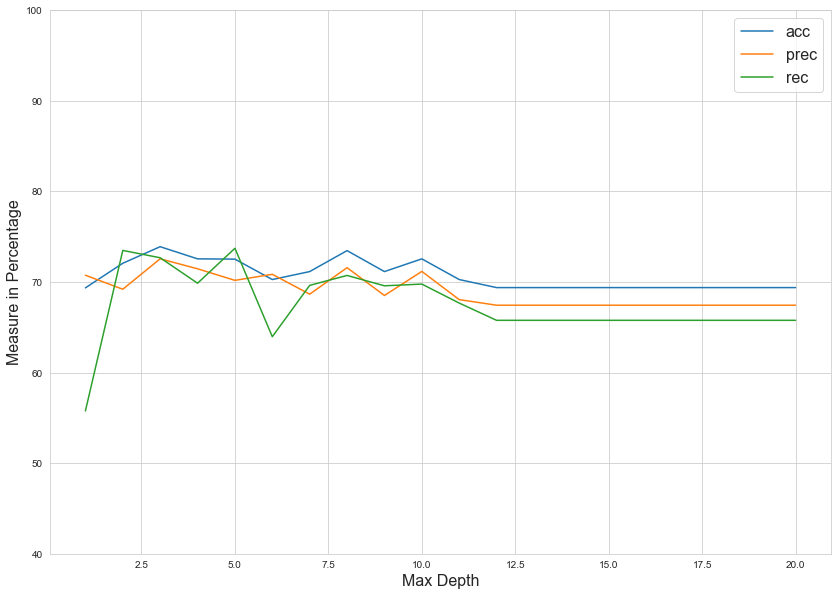

In [34]:
# We'll plot the mean measure across the folds as 
# a function of max_depth
plt.figure(figsize=(14,10))

plt.plot(range(1,max_depth+1),np.mean(accs,axis=1),label = "acc")
plt.plot(range(1,max_depth+1),np.mean(prec,axis=1),label = "prec")
plt.plot(range(1,max_depth+1),np.mean(rec,axis=1),label="rec")

plt.xlabel("Max Depth", fontsize = 16)
plt.ylabel("Measure in Percentage", fontsize = 16)

plt.ylim(40,100)

plt.legend(fontsize = 16)
plt.show()

#### Model With Non-Binary Categorical Variables

Perform one hot encoding of the non-binary categorical variables, then repeat the prior steps. Is this model better on the test data than the last one?

Which measures should we use to evaluate better in this problem?

In [26]:
## Code here
# Function to get one hot encoded
def prepare(df,cols):
    df[cols] = df[cols].astype(str)
    
    dummies = pd.get_dummies(df[cols])
    
    new_df = pd.concat([df[[c for c in df.columns if c not in cols]],dummies],axis=1, sort=False)
    

    return new_df

# One hot encode
X_train_prime = prepare(X_train,['cp','restecg','thal'])

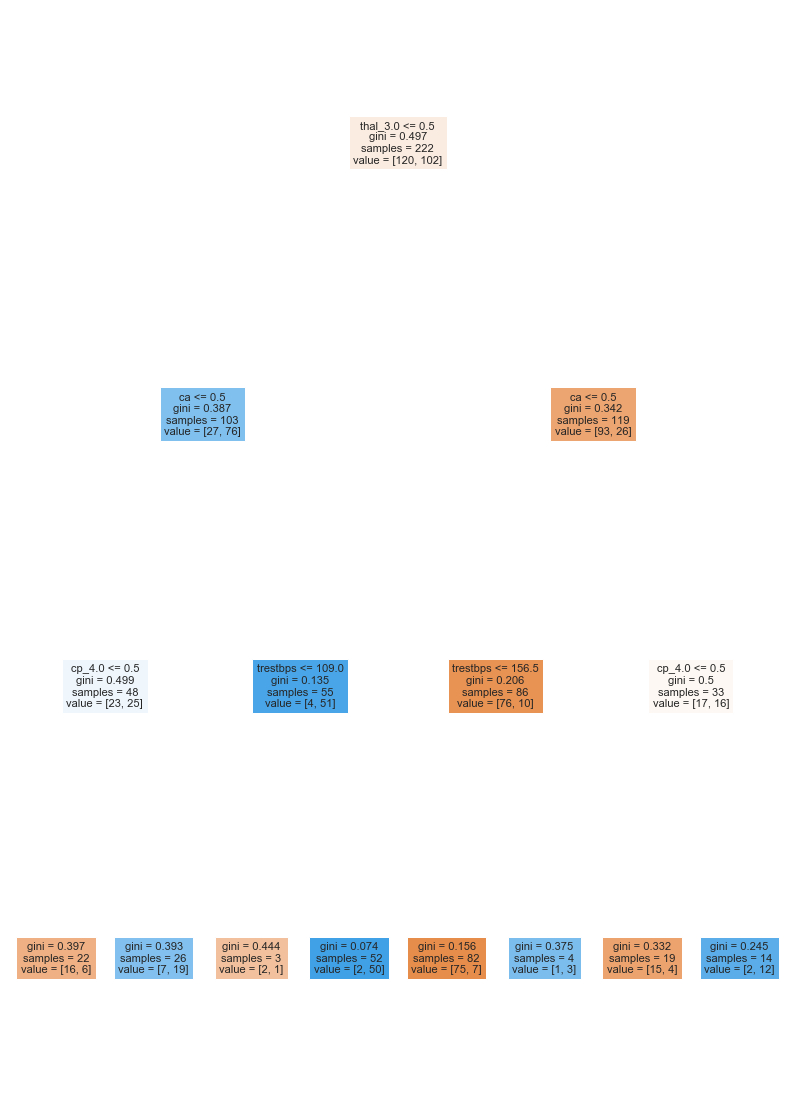

In [27]:
## Code here
# sample tree


tree_clf = DecisionTreeClassifier(random_state = 440,max_depth = 3)



plt.figure(figsize = (14,20))
# Plot the fitted tree
fig = tree_clf.fit(X_train_prime,y_train)
tree.plot_tree(fig,filled = True,rotate=True,feature_names=X_train_prime.columns)
plt.show()








In [35]:
## Code here
# make the kfold object
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, random_state = 440, shuffle=True)

max_depth = 20

# make an empty array that will hold all of our accuracy measures
accs = np.empty([max_depth,n_splits])
prec = np.empty([max_depth,n_splits])
rec = np.empty([max_depth,n_splits])

# We'll go from 1 to 10 neighbors
for i in range(1,max_depth+1):
    # make knn
    tree_clf = DecisionTreeClassifier(random_state = 440,max_depth = i)
    # We'll get the accuracy for each split
    j = 1
    for k, (train_index, test_index) in enumerate(kfold.split(X_train_prime, y_train)):
        X_train_folds = X_train_prime.loc[train_index,]
        y_train_folds = y_train.loc[train_index,]
        X_test_fold = X_train_prime.loc[test_index,]
        y_test_fold = y_train.loc[test_index,]
        
        clone_tree = clone(tree_clf)
        clone_tree.fit(X_train_folds,y_train_folds)
        y_pred = clone_tree.predict(X_test_fold)
        accs[i-1,j-1] = get_acc(y_pred.reshape(-1,1),y_test_fold.values)
        prec[i-1,j-1] = get_prec(y_pred.reshape(-1,1),y_test_fold.values)
        rec[i-1,j-1] = get_recall(y_pred.reshape(-1,1),y_test_fold.values)
        j = j+1
        








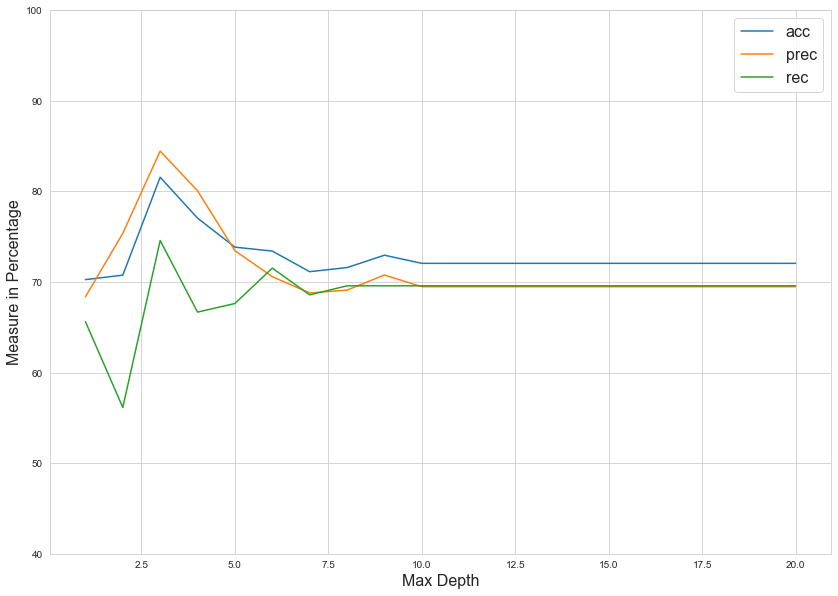

In [36]:
plt.figure(figsize=(14,10))

plt.plot(range(1,max_depth+1),np.mean(accs,axis=1),label = "acc")
plt.plot(range(1,max_depth+1),np.mean(prec,axis=1),label = "prec")
plt.plot(range(1,max_depth+1),np.mean(rec,axis=1),label="rec")

plt.xlabel("Max Depth", fontsize = 16)
plt.ylabel("Measure in Percentage", fontsize = 16)

plt.ylim(40,100)

plt.ylim(40,100)

plt.legend(fontsize = 16)
plt.show()

### Write a summary of your findings here 










## Final Thoughts on Decision Trees

Before we close the jupyter notebook on decision trees let's leave with a few take aways.

### Advantages
<ol>
    <li>Interpret-ability - Decision Trees are known as a white box algorithm (as opposed to the black box often used to describe machine learning). This is because you are able to entirely describe how a decision tree predicts a data points target using the logic tree.</li>
    <li>Very Fast Predictions</li>
    <li>Very little preprocessing of data prior to training</li>
</ol>

### Disadvantages
<ol>
    <li>Greediness - The algorithm is greedy meaning it may not create the optimal tree. For example, maybe the best tree involves an initial suboptimal cut, the CART algorithm won't find this tree.</li>
    <li>Overfitting - Decision trees are very prone to overfitting the data, you can control for this using regularization hyperparameters like max_depth and min_samples_split. It's also a good idea to use cv when you can.</li>
    <li>Orthogonal Boundaries - Because of the process of determining cut points (remember the $t_k$ from the algorithm?) decision boundaries happen at right angles. This means that classes divided by a non-horizontal or non-vertical line the decision tree will have some capturing the boundary. This can be mitigated a bit with PCA.</li>
    <li>Sensitive - Trees are very sensitive to the training data. Removing or adding a few points can greatly change the decision boundary produced by the algorithm. One way around this is to use an averaged algorithm, like a random forest. We discuss these in the next notebook.</li>
</ol>

### Getting class probabilities

You can get class probabilities from a fitted decision tree classifier using the method `predict_proba(X)` where $X$ is the feature array you want to predict on.

These probabilities can then be used to calculate AUC for hyperparameter tuning.

In [ ]:
# An example of getting tree probabilities

# Make the classifier 
tree_clf = DecisionTreeClassifier(random_state = 440,max_depth = 3)

# Fit the classifier
tree_clf.fit(X_train,y_train)

# Get the probabilities for the training set
tree_clf.predict_proba(X_train)

In [ ]:
s